<a href="https://colab.research.google.com/github/comojin1994/Deep_Learning_Study/blob/master/Kaggle/Global_Wheat_Detection/Global_Wheat_Detection_FasterRCNN_resnet50fpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import cv2

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import random

In [0]:
os.listdir('../input/global-wheat-detection')

train_dir = '../input/global-wheat-detection/train'
test_dir = '../input/global-wheat-detection/test'

df_train = pd.read_csv('../input/global-wheat-detection/train.csv')

In [0]:
print(df_train.head())
print(df_train.shape)

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1
(147793, 5)


In [0]:
print(len(df_train['image_id'].unique()))
print((df_train.shape[0]) / len(df_train['image_id'].unique()))

3373
43.8164838422769


In [0]:
print('Image_id v/s # of bounding boxes')
print(df_train['image_id'].value_counts())

Image_id v/s # of bounding boxes
35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
b70c20580     97
            ... 
6a62af644      1
79c8a1627      1
4e6c05213      1
41457a646      1
86296fc32      1
Name: image_id, Length: 3373, dtype: int64


In [0]:
df_train[df_train['image_id']=='86296fc32']

,image_id,width,height,bbox,source
121449,86296fc32,1024,1024,"[701.0, 284.0, 64.0, 228.0]",arvalis_3


In [0]:
print('Height')
print(df_train['height'].value_counts())
print('Width')
print(df_train['width'].value_counts())

Height
1024    147793
Name: height, dtype: int64
Width
1024    147793
Name: width, dtype: int64


In [0]:
list_image_ids_df = list(df_train['image_id'].unique())
list_image_ids_dir = os.listdir('../input/global-wheat-detection/train/')

In [0]:
len(list_image_ids_dir) - len(list_image_ids_df)

49

In [0]:
for col in df_train.columns:
    if sum(df_train[col].isnull()) == 1:
        print(col + ' has null values')
    else:
        print(col + ' no null values')

image_id no null values
width no null values
height no null values
bbox no null values
source no null values


In [0]:
df_train.head()

,image_id,width,height,bbox,source,x0
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0


In [0]:
df_train['x0'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[0]).astype(float)
df_train['y0'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[1]).astype(float)
df_train['w'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[2]).astype(float)
df_train['h'] = df_train['bbox'].map(lambda x: x[1:-1].split(',')[3]).astype(float)
df_train['x1'] = df_train['x0'] + df_train['w']
df_train['y1'] = df_train['y0'] + df_train['h']

In [0]:
df_train.head()

,image_id,width,height,bbox,source,x0,y0,w,h,x1,y1
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [0]:
for col in df_train.columns:
    if sum(df_train[col].isnull()) == 1:
        print(col + ' has null values')
    else:
        print(col + ' no null values')

image_id no null values
width no null values
height no null values
bbox no null values
source no null values
x0 no null values
y0 no null values
w no null values
h no null values
x1 no null values
y1 no null values


In [0]:
df_train.dtypes

image_id     object
width         int64
height        int64
bbox         object
source       object
x0          float64
y0          float64
w           float64
h           float64
x1          float64
y1          float64
dtype: object

In [0]:
cols_to_be_selected = ['image_id', 'x0', 'y0', 'x1', 'y1']
df1_train = df_train[cols_to_be_selected]

In [0]:
len(df1_train['image_id'].unique())

3373

In [0]:
val_percentage = 0.2
num_val_images = int(len(df1_train['image_id'].unique()) * val_percentage)
num_train_images = len(df1_train['image_id'].unique()) - num_val_images
list_val_imageid = list(df1_train['image_id'].unique())[(-1) * num_val_images:]
list_train_imageid = list(df1_train['image_id'].unique())[:num_train_images]

In [0]:
print('Number of validation images: ', num_val_images)
print('Number of training images: ', num_train_images)
print(num_val_images + num_train_images)

Number of validation images:  674
Number of training images:  2699
3373


In [0]:
df2_val = df1_train.loc[df1_train['image_id'].isin(list_val_imageid), :]
df2_train = df1_train.loc[df1_train['image_id'].isin(list_train_imageid), :]

In [0]:
def get_transform():
    list_transforms = []
    list_transforms.append(transforms.ToTensor())
    return transforms.Compose(list_transforms)

In [0]:
class GlobalWheatDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, input_df, input_dir, transforms=None):
        
        self.df = input_df
        self.list_images = list(self.df['image_id'].unique())
        self.image_dir = input_dir
        self.transforms = transforms
        
    def __getitem__(self, idx):
        cols_to_be_selected = ['x0', 'y0', 'x1', 'y1']
        img_id = self.list_images[idx]
        bboxes_array = np.array(self.df.loc[self.df['image_id'] == img_id, cols_to_be_selected])
        boxes = torch.tensor(bboxes_array, dtype=torch.int64)
        
        num_boxes = self.df.loc[self.df['image_id'] == img_id].shape[0]
        labels = torch.ones(num_boxes, dtype=torch.int64)
        
        area = torch.tensor(np.array((self.df['x1'] - self.df['x0']) * (self.df['y1'] - self.df['y0'])), dtype=torch.int64)
        
        iscrowd = torch.zeros(num_boxes, dtype=torch.uint8)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        img = cv2.imread(self.image_dir + '/' + img_id + '.jpg')
        img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_scaled = img_RGB/255.0
        img_final = img_scaled
        
        if self.transforms is not None:
            img_final = self.transforms(img_final)
            
        return img_final, target, img_id
    
    def __len__(self):
        return len(self.df['image_id'].unique())

In [0]:
train_dataset = GlobalWheatDetectionDataset(df2_train, train_dir, get_transform())
val_dataset = GlobalWheatDetectionDataset(df2_val, train_dir, get_transform())

In [0]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [0]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [0]:
image, target, image_id = train_dataset[0]
image = image.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


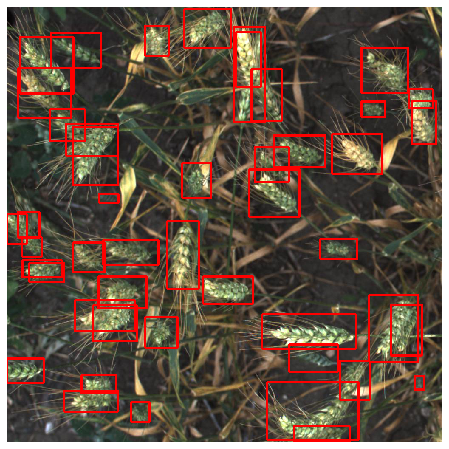

In [0]:
boxes = target['boxes'].cpu().numpy().astype(np.int32)
sample = image.permute(1, 2, 0).cpu().numpy().astype(np.float32)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                 (box[0], box[1]),
                 (box[2], box[3]),
                 (255, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)
plt.show()

In [0]:
torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/sungjinkim/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
14.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [0]:
def get_instance_objectdetection_model(num_classes, path_weight):
    create_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
    
    in_features = create_model.roi_heads.box_predictor.cls_score.in_features
    
    create_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    create_model.load_state_dict(torch.load(path_weight, map_location=torch.device('cpu')))
    
    return create_model

In [0]:
path_weight = '../input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth'

In [0]:
num_classes = 2
model = get_instance_objectdetection_model(num_classes, path_weight)

In [0]:
torch.cuda.empty_cache()

In [0]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [0]:
mode = 'training'

In [0]:
if mode == 'training':
    model.train()
    model.to(device)
    
    num_epochs = 2
    
    itr = 1
    
    for epoch in range(num_epochs):
        loss_sum = 0
        num_iterations = 0
        for images, targets, image_ids in train_dataloader:
            
            images = list(image.to(device, dtype=torch.float) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            
            loss_sum = loss_sum + loss_value
            num_iterations = num_iterations + 1
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            if itr % 5 == 0:
                print(f'Iteration #{itr} loss: {loss_value}')
                
            itr += 1
            
        if lr_scheduler is not None:
            lr_scheduler.step()
            
        if num_iterations > 0:
            loss_avg_value = loss_sum / num_iterations
            
        print('Epoch' + '#' + str(epoch) + ' loss: ' + str(loss_avg_value))

RuntimeError: DataLoader worker (pid(s) 1821) exited unexpectedly

In [0]:
images, targets, image_id = next(iter(train_dataloader))

In [0]:
targets[0].items()

dict_items([('boxes', tensor([[651.5625, 173.4375, 695.3125, 201.5625],
        [176.5625, 428.1250, 278.1250, 473.4375],
        [294.5312, 393.7500, 352.3438, 518.7500],
        [651.5625,  74.2188, 736.7188, 157.8125],
        [ 20.3125, 112.5000, 117.1875, 203.9062],
        [444.5312, 298.4375, 537.5000, 385.1562],
        [ 40.6250, 470.3125, 104.6875, 505.4688],
        [489.8438, 235.9375, 585.1562, 294.5312],
        [321.8750, 286.7188, 375.0000, 350.7812],
        [744.5312, 171.8750, 788.2812, 252.3438],
        [ 23.4375,  54.6875, 121.8750, 158.5938],
        [ 27.3438, 422.6562,  63.2812, 458.5938],
        [ 80.4688,  46.8750, 171.8750, 111.7188],
        [325.7812,   3.1250, 411.7188,  74.2188],
        [596.8750, 233.5938, 689.8438, 306.2500],
        [421.0938,  45.3125, 466.4062, 146.8750],
        [108.5938, 214.0625, 203.1250, 273.4375],
        [360.1562, 495.3125, 452.3438, 545.3125],
        [167.9688, 495.3125, 256.2500, 553.9062],
        [104.6875, 705.4688,